 # 1. Exploración teórica de las señales ECG y variables del dataset
## Contexto del problema

La fibrilación auricular (AFib) es una de las arritmias cardíacas más comunes. Se caracteriza por latidos cardíacos irregulares y, a menudo, rápidos. Su detección oportuna es fundamental, ya que puede prevenir complicaciones graves como accidentes cerebrovasculares, insuficiencia cardíaca y otras enfermedades cardíacas.

Los ECG (electrocardiogramas) son la herramienta estándar para diagnosticar arritmias. Sin embargo, interpretar grandes volúmenes de señales ECG de forma manual es poco escalable. Aquí es donde entra el modelo de ML entrenado para detectar patrones en los datos. Estos modelos pueden ayudar a automatizar el proceso de diagnóstico, reduciendo errores humanos y permitiendo análisis a gran escala, sirviendo de apoyo para el diagnostico de los medicos especializados en el tema.

## Utilidad del modelo de Machine Learning

El modelo a desarrollar tendrá como objetivo:

- Clasificar segmentos de señal ECG usando solo información extraída de los intervalos RR.

- Distinguir entre ritmo normal y fibrilación auricular.

- Servir como base para un sistema de monitoreo automatizado que pueda alertar de forma temprana al paciente o médico tratante.


## Importancia de cada variable del dataset

| Variable     | Descripción técnica                                                                                   | Relevancia para la clasificación                                                                                      |
| ------------ | ----------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| **mean\_rr** | Promedio de los intervalos RR (en milisegundos). Refleja el **ritmo cardíaco promedio** del segmento. | En AFib suele haber un promedio más bajo (taquicardia) o muy variable. En ritmo normal es más constante.              |
| **std\_rr**  | Desviación estándar de los intervalos RR. Indica la **variabilidad del ritmo**.                       | En AFib hay una **alta variabilidad**; en ritmo normal, es menor.                            |
| **skew\_rr** | Asimetría de la distribución de RR. Mide si los intervalos son más frecuentes en un extremo.          | AFib puede producir distribuciones asimétricas debido a latidos muy cortos o largos intercalados.                     |
| **kurt\_rr** | Curtosis de la distribución de RR. Mide la **concentración de valores alrededor de la media**.        | En AFib, los valores pueden estar más dispersos, lo que lleva a curtosis baja; en ritmo normal, pueden agruparse más. |
| **label**    | Clase del segmento: `Normal` o `AFib`.                                                                | Etiqueta supervisada para entrenar y evaluar el modelo.                                                               |


En lugar de procesar señales crudas (que es complejo y requiere alto poder de cómputo), este enfoque reduce la dimensionalidad y complejidad al utilizar características estadísticas ya extraídas. Esto tiene varias ventajas:

- Permite entrenar modelos simples con pocos datos.

- Es interpretable: cada atributo tiene un significado clínico claro.




## Visualización del electrocardiograma




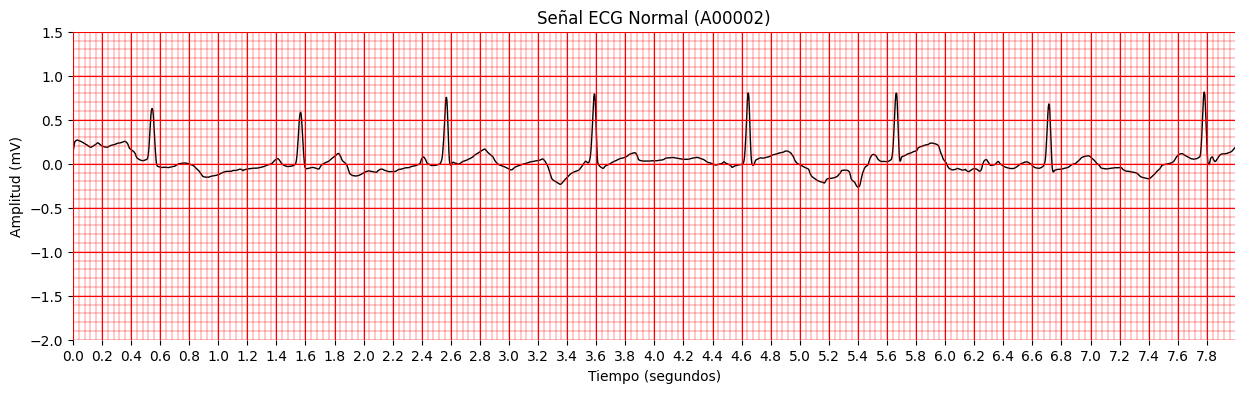

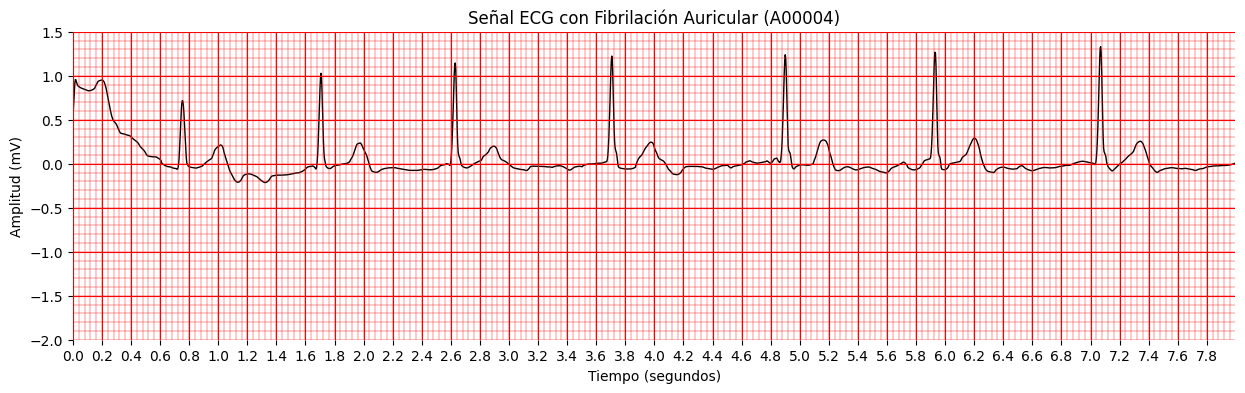

In [6]:
import wfdb
import matplotlib.pyplot as plt
import os
import numpy as np

# Ruta donde están los archivos .mat y .hea
ruta_carpeta = './proyecto/training2017' 

# Registros de ejemplo: uno normal y otro con AFib
registro_normal = 'A00002'
registro_afib = 'A00004'

# Cargar registros
record_n = wfdb.rdrecord(os.path.join(ruta_carpeta, registro_normal))
record_a = wfdb.rdrecord(os.path.join(ruta_carpeta, registro_afib))

# Señales y frecuencias de muestreo
signal_n = record_n.p_signal[:, 0]
signal_a = record_a.p_signal[:, 0]
fs_n = int(record_n.fs)
fs_a = int(record_a.fs)

# Definir ventana de tiempo para mostrar (segundos)
duracion_segundos = 8

# Crear eje de tiempo en segundos para cada señal (solo la ventana)
t_n = np.arange(len(signal_n)) / fs_n
t_a = np.arange(len(signal_a)) / fs_a

# Limitar señales y tiempo a la duración deseada
max_muestra_n = min(len(signal_n), fs_n * duracion_segundos)
max_muestra_a = min(len(signal_a), fs_a * duracion_segundos)

t_n = t_n[:max_muestra_n]
signal_n = signal_n[:max_muestra_n]

t_a = t_a[:max_muestra_a]
signal_a = signal_a[:max_muestra_a]

def plot_ecg(signal, time, titulo, color='black'):
    plt.plot(time, signal, color=color, linewidth=1)

    # Límites
    plt.xlim([time[0], time[-1]])
    plt.ylim([-1.5, 1.5])  # Puedes ajustar según tu señal

    # Cuadrícula: líneas cada 0.04s (pequeñas) y cada 0.2s (gruesas)
    major_grid_x = np.arange(0, time[-1], 0.2)
    minor_grid_x = np.arange(0, time[-1], 0.04)
    major_grid_y = np.arange(-2, 2, 0.5)
    minor_grid_y = np.arange(-2, 2, 0.1)

    plt.xticks(major_grid_x)
    plt.yticks(major_grid_y)

    # Líneas de cuadrícula menores (rojas, finas)
    for x in minor_grid_x:
        plt.axvline(x=x, color='red', linewidth=0.3, linestyle='-')
    for y in minor_grid_y:
        plt.axhline(y=y, color='red', linewidth=0.3, linestyle='-')

    # Líneas de cuadrícula mayores (rojas, más gruesas)
    for x in major_grid_x:
        plt.axvline(x=x, color='red', linewidth=0.8)
    for y in major_grid_y:
        plt.axhline(y=y, color='red', linewidth=0.8)

    plt.title(titulo, fontsize=12)
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud (mV)')
    plt.grid(False)
    plt.box(False)

# Reemplaza tu parte de graficar por esto:
plt.figure(figsize=(15, 4))
plot_ecg(signal_n, t_n, f'Señal ECG Normal ({registro_normal})')
plt.show()

plt.figure(figsize=(15, 4))
plot_ecg(signal_a, t_a, f'Señal ECG con Fibrilación Auricular ({registro_afib})')
plt.show()



## Procesamiento de las señales a variables y generación de los datos curados


In [22]:
from wfdb.processing import xqrs_detect
from scipy.stats import skew, kurtosis
import numpy as np

def calcular_metricas_rr(signal, fs):
    # Detectar picos R con XQRS
    r_peaks = xqrs_detect(sig=signal, fs=fs)

    #Validar que hayan almenos 4 picos, de lo contrario son demasiado pocos para calcular
    if len(r_peaks) < 4:
        return None

    # Calcular intervalos RR en milisegundos
    rr_intervals = np.diff(r_peaks) / fs * 1000  # en ms

    # Filtramos intervalor RR demasiado pequeños o extremos
    rr_intervals = rr_intervals[(rr_intervals > 200) & (rr_intervals < 2000)]
    if len(rr_intervals) < 3:
        return None


    # Calcular métricas
    meanrr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    skew_rr = skew(rr_intervals)
    kurt_rr = kurtosis(rr_intervals)

    # Aplicar filtros de validación
    if not (300 <= meanrr <= 2000):
        return None
    if not (5 <= std_rr <= 1000):
        return None


    return meanrr, std_rr, skew_rr, kurt_rr


In [ ]:
import wfdb
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import skew, kurtosis

# Ruta y carga de referencias
ruta_carpeta = './proyecto/training2017'
ruta_referencia = os.path.join(ruta_carpeta, 'REFERENCE.csv')
df_referencia = pd.read_csv(ruta_referencia, header=None, names=['file', 'clase'])

#Quitamos las muestras de datos que no usaremos, O y ~
mapa_clases = {
    'N': 'Normal',
    'A': 'AFib',
    'O': 'Otro',
    '~': 'Ruido'
}

df_referencia['label'] = df_referencia['clase'].map(mapa_clases)
df_referencia = df_referencia[df_referencia['label'].isin(['Normal', 'AFib'])]

resultados = []

for idx, fila in df_referencia.iterrows():
    archivo = fila['file']
    etiqueta = fila['label']

    try:
         # Leer el registro
        record = wfdb.rdrecord(os.path.join(ruta_carpeta, archivo))

        # Tomar solo el primer canal
        signal = record.p_signal[:, 0]
        fs = int(record.fs)

        # Llamar a la función de métricas
        meanrr, std_rr, skew_rr, kurt_rr = calcular_metricas_rr(signal, fs)

        # Guardar resultados
        resultados.append({
            'archivo': archivo,
            'label': etiqueta,
            'mean_rr': meanrr,
            'std_rr': std_rr,
            'skew_rr': skew_rr,
            'kurt_rr': kurt_rr
        })


    except Exception as e:
        print(f"Error procesando {archivo}: {e}")

df_caracteristicas = pd.DataFrame(resultados)

# Estadísticas para validación
#print(df_caracteristicas.groupby('label')[['mean_rr', 'std_rr']].describe())

# Guardar (Descomentar para generar el dataset como csv)
# df_caracteristicas.to_csv('ecg_rr_features_curado.csv', index=False)



# Visualización de los datos 

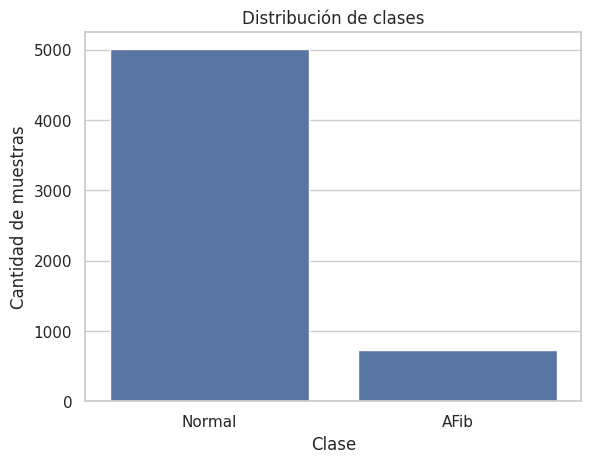

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('ecg_rr_features_curado.csv')

sns.countplot(data=df, x='label')
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad de muestras')
plt.show()

In [45]:

df_normal = df[df['label'] == 'Normal']
df_afib = df[df['label'] == 'AFib']

print("Estadísticas ECG Normales:")
print(df_normal.describe())

print("\nEstadísticas ECG con Fibrilación Auricular (AFib):")
print(df_afib.describe())

# Balancear el dataset solo para gráficos
df_balanced = df.groupby('label')
#df_balanced.describe()

Estadísticas ECG Normales:
           mean_rr       std_rr      skew_rr      kurt_rr
count  5008.000000  5008.000000  5008.000000  5008.000000
mean    843.617871    73.267334    -0.774668     3.143295
std     133.315092    68.397236     1.627248     6.715352
min     351.646586     5.009456    -7.034768    -1.818528
25%     742.812500    23.201192    -1.562966    -0.612631
50%     836.330532    47.679737    -0.320547     0.159132
75%     931.833931   103.723725     0.210097     3.859728
max    1261.739130   680.943427     6.825154    51.997085

Estadísticas ECG con Fibrilación Auricular (AFib):
           mean_rr      std_rr     skew_rr     kurt_rr
count   731.000000  731.000000  731.000000  731.000000
mean    703.705424  150.357611    0.670873    1.287743
std     199.566491   72.195891    0.995641    3.821437
min     306.426117   19.314434   -4.254832   -1.970744
25%     552.123472   96.073832    0.221162   -0.512000
50%     682.708333  139.295787    0.684503    0.255419
75%     820.38

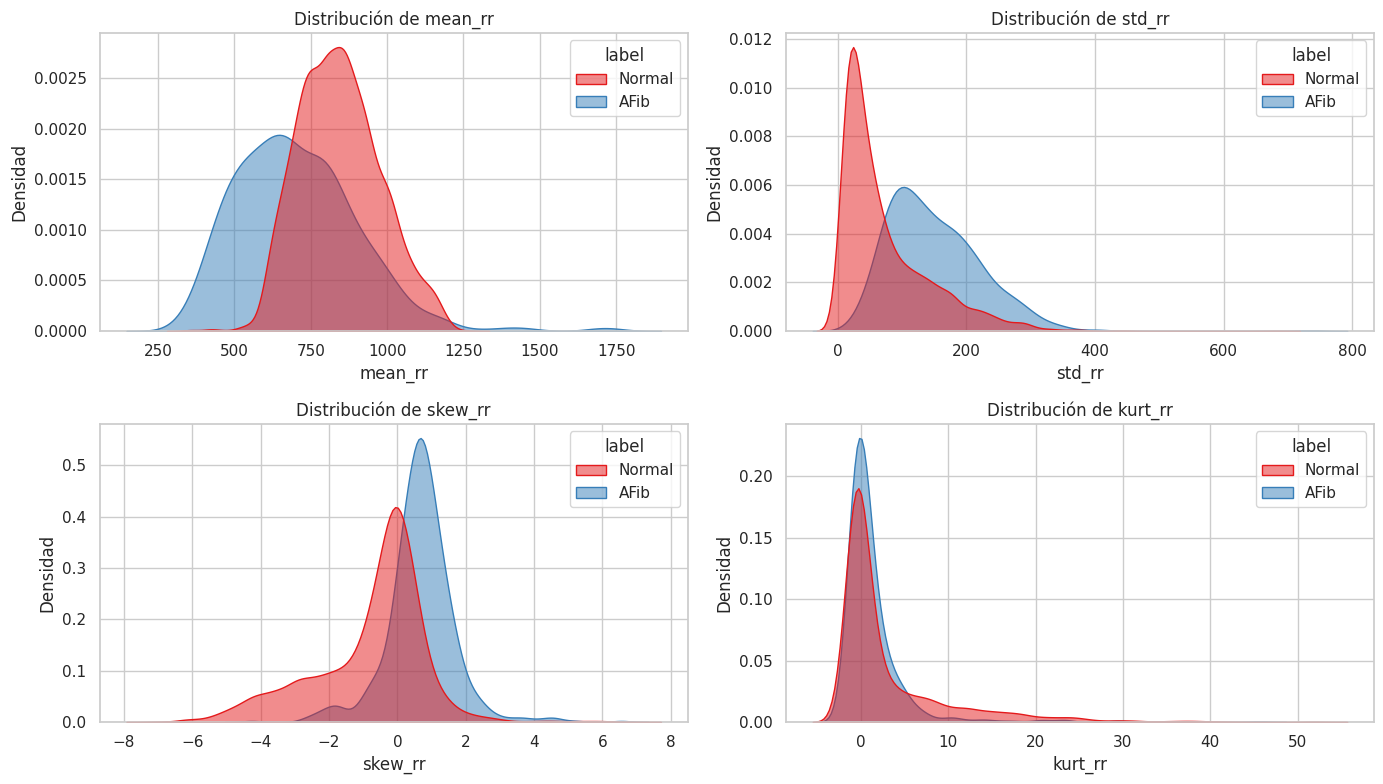

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Distribuciones (KDE) de cada métrica
plt.figure(figsize=(14, 8))

for i, feature in enumerate(['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data=df, x=feature, hue='label', fill=True, common_norm=False, palette='Set1', alpha=0.5)
    plt.title(f'Distribución de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densidad')

plt.tight_layout()
plt.show()


# Análisis general de datos 
1. mean_rr (intervalo RR medio)
    - ECG Normales:
        - Media ≈ 844 ms → Esto equivale a una frecuencia cardíaca promedio de ~71 bpm (60,000 ms/min ÷ 844 ms).
        - Esto es perfectamente plausible para personas sanas en reposo.

    - ECG AFib:
        - Media ≈ 704 ms → Frecuencia cardíaca de ~85 bpm.
        - La fibrilación auricular suele causar una frecuencia más rápida y variable, por lo que este valor más bajo que en normales es esperado.

mean_rr tiene sentido y refleja diferencias fisiológicas entre normales y AFib.

2. std_rr (desviación estándar del intervalo RR)
    - ECG Normales:
        - Media ≈ 73 ms con desviación ≈ 68 ms.
        - La variabilidad normal del ritmo cardíaco en reposo suele ser baja pero presente (lo que se llama variabilidad de la frecuencia cardíaca o HRV).

    - ECG AFib:
        - Media ≈ 150 ms con desviación ≈ 72 ms.
        - AFib genera una variabilidad mucho mayor en los intervalos RR debido a la naturaleza irregular del ritmo, por eso la desviación más alta tiene sentido.

std_rr se comporta como esperado y muestra mayor variabilidad en AFib.

3. skew_rr (asimetría de los intervalos RR)
    - ECG Normales:
        - Media ≈ -0.77 (asimetría negativa).
        - Esto indica que la distribución de intervalos RR está sesgada hacia valores menores (latidos más rápidos), pero la mayoría de los valores están cerca de la media o un poco mayores. Esto puede reflejar la fisiología normal del ritmo cardíaco.

    - ECG AFib:
        - Media ≈ +0.67 (asimetría positiva).
        - Esto indica que la distribución tiene cola a la derecha, es decir, hay más valores grandes en los intervalos RR (latidos irregulares y a veces lentos), característico de arritmias.

skew_rr refleja diferencias esperables y aporta información sobre la irregularidad y dirección de la distribución.

4. kurt_rr (curtosis de los intervalos RR)
    - ECG Normales:
        - Media ≈ 3.14, que está cerca del valor de 3 para una distribución normal (mesocúrtica).
        - Esto indica que los intervalos RR tienen una distribución relativamente “normal” sin colas extremadamente pesadas.

    - ECG AFib:
        - Media ≈ 1.29, menor que 3, indica una distribución más plana (platicúrtica), con colas menos pesadas, más dispersa. Esto es coherente con la irregularidad en AFib.

kurt_rr también tiene sentido en este contexto y confirma la diferencia en la forma de la distribución entre normales y AFib.


## ¿Qué variables parecen diferenciar más entre clases?

Las siguientes variables muestran mayor poder discriminativo entre las clases (Normal vs AFib):
1. mean_rr (Intervalo RR medio)

    - ECG Normal tiene valores más altos en promedio (~843 ms), lo que sugiere frecuencias cardíacas más bajas y regulares.
    - AFib muestra valores menores (~703 ms), indicando frecuencia cardíaca más elevada e irregular.
    - La diferencia es considerable y visible en la separación de las curvas KDE.
    - Esto tiene sentido porque en AFib el corazón tiende a latir más rápido y de forma desorganizada.
2. std_rr (Desviación estándar de los intervalos RR)
    - Normal: std ≈ 73 ms → baja variabilidad entre latidos.
    - AFib: std ≈ 150 ms → alta variabilidad, típica de arritmias.
    - La variabilidad del ritmo cardíaco es una de las características más claras en pacientes con fibrilación auricular.

## ¿Qué aspectos del dataset llaman la atención?
1. Desbalance de clases:
    - Hay muchos más ejemplos normales (5008) que de AFib (731).
    - Esto puede afectar modelos de clasificación si no se balancea o ajusta adecuadamente.

2. Valores extremos / outliers:
    - Antes de filtrar, había valores como mean_rr de menos de 300 ms (equivalente a 200 latidos por minuto), lo cual es fisiológicamente improbable.
    - El filtrado mejora la calidad del dataset y evita que modelos aprendan patrones erróneos o ruidosos.

3. No se están usando características morfológicas:
    - Todas las variables se basan en intervalos RR (tiempo entre latidos).
    - Sería interesante (en una etapa posterior) incluir medidas basadas en la forma de la onda (amplitud P, QRS, T, etc.) si estuvieran disponibles, ya que enriquecería mucho el análisis.

# 2 Entrenamiento de un modelo base (Random Forest)
Para construir un modelo capaz de clasificar entre señales de ECG normales y aquellas con fibrilación auricular (AFib), se utilizará un algoritmo de Random Forest. Este algoritmo es una opción ya que combina múltiples árboles de decisión para mejorar el rendimiento y controlar el sobreajuste.

En este paso, utilizaremos las características previamente extraídas a partir de los intervalos RR: mean_rr, std_rr, skew_rr y kurt_rr.

## Preparación del conjunto de datos

Primero, cargamos los datos desde el archivo CSV, separamos las variables predictoras de la variable objetivo (label) y codificamos las clases en formato numérico.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cargar el archivo con características
df = pd.read_csv('ecg_rr_features_curado.csv')

# Seleccionar las variables predictoras
X = df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]

# Variable objetivo (label)
y = df['label']

# Codificar la clase (Normal = 0, AFib = 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir el dataset en entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# Se utiliza stratify=y_encoded para mantener la proporción de clases en ambos subconjuntos, lo que asegura una evaluación más representativa.
#Este parámetro garantiza que la proporción de clases (AFib y Normal) sea la misma tanto en el conjunto de entrenamiento como en el de prueba.
#Sin stratify, podría ocurrir que una clase quede sobrerepresentada en uno de los subconjuntos, generando resultados sesgados o no representativos.


## Entrenamiento del modelo


In [2]:
# Crear y entrenar el clasificador Random Forest con 100 árboles
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## Evaluación del modelo
Una vez entrenado el modelo, evaluamos su desempeño sobre el conjunto de prueba mediante métricas como accuracy, reporte de clasificación y matriz de confusión.


In [4]:
# Predicciones sobre los datos de prueba
y_pred = clf.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.3f}")


Accuracy del modelo: 0.963


Esto indica que el 96.3% de todas las predicciones del modelo fueron correctas.

Este valor global es bueno, pero no nos dice cómo se comporta el modelo con cada clase (por ejemplo, si detecta bien la AFib).

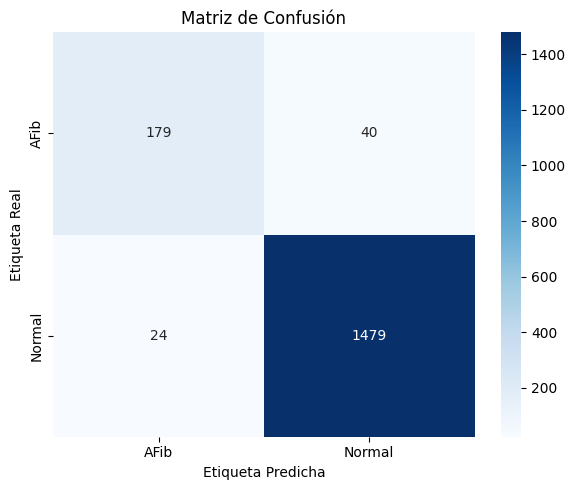

In [9]:
# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Asumiendo que ya tienes y_test y y_pred
cm = confusion_matrix(y_test, y_pred)
labels = ['AFib', 'Normal']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.tight_layout()
plt.show()



    - TP (True Positive): 179 → Casos de AFib correctamente clasificados.

    - FN (False Negative): 40 → Casos de AFib clasificados como Normal.

    - FP (False Positive): 24 → Casos normales clasificados como AFib.

    - TN (True Negative): 1479 → Casos normales correctamente clasificados.

El modelo se **equivoca** más al clasificar AFib como normal (40 veces) que al revés (24 veces). Esto es importante porque en contextos médicos los falsos negativos (no detectar una arritmia) pueden ser críticos.

In [6]:

# Reporte de clasificación detallado (precision, recall, f1-score)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Reporte de clasificación:
              precision    recall  f1-score   support

        AFib       0.88      0.82      0.85       219
      Normal       0.97      0.98      0.98      1503

    accuracy                           0.96      1722
   macro avg       0.93      0.90      0.91      1722
weighted avg       0.96      0.96      0.96      1722



Por clase:
    - AFib:

        - Precision = 0.88: De todos los que el modelo predijo como AFib, el 88% realmente lo eran.

        - Recall = 0.82: De todos los verdaderos casos de AFib, el modelo detectó el 82%.

        - F1-score = 0.85: Balance entre precisión y recall.

    - Normal:

        - Precision = 0.97: De los predichos como normales, el 97% eran normales.

        - Recall = 0.98: De todos los verdaderos normales, el modelo detectó el 98%.

        - F1-score = 0.98: Excelente desempeño.

Promedios:

    - macro avg: Promedio simple entre clases (sin ponderar). Es útil para ver si el modelo trata a ambas clases por igual.

    - weighted avg: Promedio ponderado por la cantidad de muestras en cada clase. Refleja más la clase mayoritaria (Normal en este caso).

## Conclusión

Los resultados obtenidos a partir del modelo de Random Forest aplicado sobre las características derivadas de los intervalos RR muestran un desempeño altamente satisfactorio en la tarea de clasificación entre ritmos cardíacos normales y casos de fibrilación auricular (AFib). Con una precisión global del **96.3%**, el modelo logra identificar correctamente la mayoría de los registros, destacando una excelente capacidad para reconocer ritmos normales **(recall de 0.98)** y una muy buena sensibilidad ante casos de AFib **(recall de 0.82)**.

Este rendimiento se ve reflejado también en el F1-score ponderado de **0.96**, que evidencia un buen equilibrio entre precisión y cobertura. Además, los valores de precisión y f1-score superiores al **0.85** para ambas clases indican que el modelo no solo generaliza bien, sino que también mantiene una coherencia en su capacidad predictiva sin depender exclusivamente de la clase mayoritaria.

La matriz de confusión revela que el modelo comete relativamente pocos errores, siendo más propenso a confundir casos de AFib como normales (40 falsos negativos) que a la inversa (24 falsos positivos). Aunque esto puede considerarse una limitación, el bajo número de errores absolutos y el mantenimiento de métricas sólidas en ambas clases refuerzan la confiabilidad del modelo para tareas de detección automatizada de ritmos cardíacos.

Cabe destacar que todo el análisis se ha realizado únicamente con características temporales extraídas de los intervalos RR. Aun así, se logró construir un clasificador eficaz, Las métricas seleccionadas (media, desviación estándar, asimetría y curtosis) han demostrado ser informativas y discriminantes, especialmente la std_rr, que mostró mayor dispersión en registros con AFib, coherente con la naturaleza irregular de esta arritmia.

A pesar del buen desempeño general del modelo, es importante reconocer que los errores de clasificación —especialmente los falsos negativos (AFib clasificados como normales)— pueden tener consecuencias clínicas significativas. Un diagnóstico erróneo de fibrilación auricular puede retrasar el tratamiento y aumentar el riesgo de eventos graves como accidentes cerebrovasculares. Por eso, incluso con una alta precisión, cualquier modelo automatizado aplicado a un entorno clínico debe ser evaluado con cautela y complementar, pero no reemplazar, el juicio médico.

Además, el modelo se entrena únicamente con características derivadas de los intervalos RR, lo que limita su capacidad para capturar otros aspectos relevantes del ECG, como alteraciones morfológicas en la onda P, el complejo QRS o la onda T. Esta restricción, sumada a posibles sesgos en el conjunto de entrenamiento, sugiere que hay espacio para mejorar la robustez y generalización del sistema, especialmente al aplicarse a poblaciones más diversas o señales con ruido. Por tanto, es fundamental seguir explorando nuevas características y validar el modelo en contextos reales para garantizar su fiabilidad.